# TTM4133- Exploring LTE Network (RAN + EPC)
This lab covers the basic concepts of data and control plane within Long Term Evolution (LTE) including connectivity between user equipment (UE) and enhanced Node-B (eNB) in Radio Access Network (RAN), enhanced packet core (EPC) and data communication within and outside the cellular LTE environment. We will cover different network states at physical (PHY), radio resource control (RRC), and, non-access stratum (NAS) during the connection setup and data transmission phases. Moreover, the conditions for these state changes will be explored with different sets of parameters. <br>
Following is a short summary of the objectives for this lab:
- Understand the RAN, EPC, and, interconnections between these LTE sub-networks
- Explore the signaling milestones during connection, disconnection and data transfer using the LTE infrastructure
- Data communication within and outside the LTE network.

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## 1. Introduction
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
In this lab, we consider a single cell LTE network with 3 static users distributed as per defined parameter **d1**. LTE network consists of two fundamental sub-network: RAN and EPC. RAN provides the interface for different types of LTE subscribers in accordance with defined UE types. EPC processes the service requests and is responsible for the provisioning of resources, mobility, localization and data communication of UEs within and outside the LTE network. Fig. 1 provides a basic topology of an LTE network for the purpose of this lab. A stream is established between each user and a remote server for traffic flows. We will be more concerned about the user plane and occasional control plane functions as required. Ns-3 provides an extensive support for various features from basic topology models to handover, pathloss and transmission models. <br>

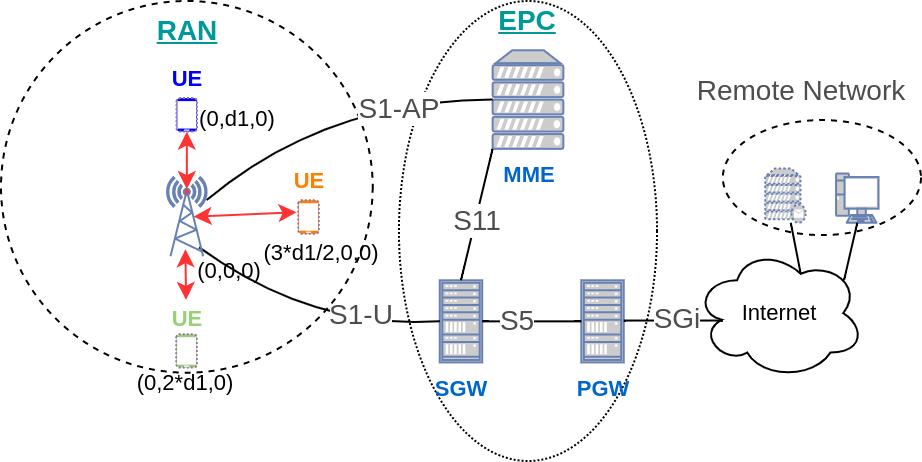
<center>
    <b>Figure. 1: Network Topology.</b>
</center>

# Parameters
We will use the following parameters to help run different simulations in order to gather and visualize the generated results:
- <u>d1</u> --> To modify user position
- <u>enableInstTput</u> -> To collect instantaneous throughput from the simulation

# Logging Sources
We will use the following logging sources from ns3 to help run different simulations in order to observe connectivity events:
**RAN**
- <u>LteEnbMac</u> --> To observe eNB MAC layer events
- <u>LteRrcProtocolIdeal</u> -> To observe LTE RRC level events
- <u>LteEnbRrc</u> --> To observe eNB RRC layer events
- <u>LteUeRrc</u> -> To observe UE RRC layer events
**EPC**
- <u>EpcMmeApplication</u> --> To observe MME application events
- <u>EpcPgwApplication</u> -> To observe PGW application events
- <u>EpcEnbApplication</u> --> To observe eNB application events
- <u>EpcSgwApplication</u> -> To observe SGW application events

# LTE Protocol Stack
The LTE protocol stack (depicted in Fig. 2) consists of following sub-protocols responsible for the range of functionalities supported in the network. Following is a basic description of these protocols: <br> <br>
**1- RRC (radio resource control)**
It is responsible for communication of system information between different nodes, establishment, management, maintenance and functionality of resources in the network. <br>
**2- PDCP (packet data convergence control)**
It is responsible for mapping LTE protocol onto IP network, in-order delivery, security and integrity services. <br>
**3- RLC (radio link control)**
It is responsible for control and management of upper layer protocols over the radio network through different modes of operation.  <br>
 <br>

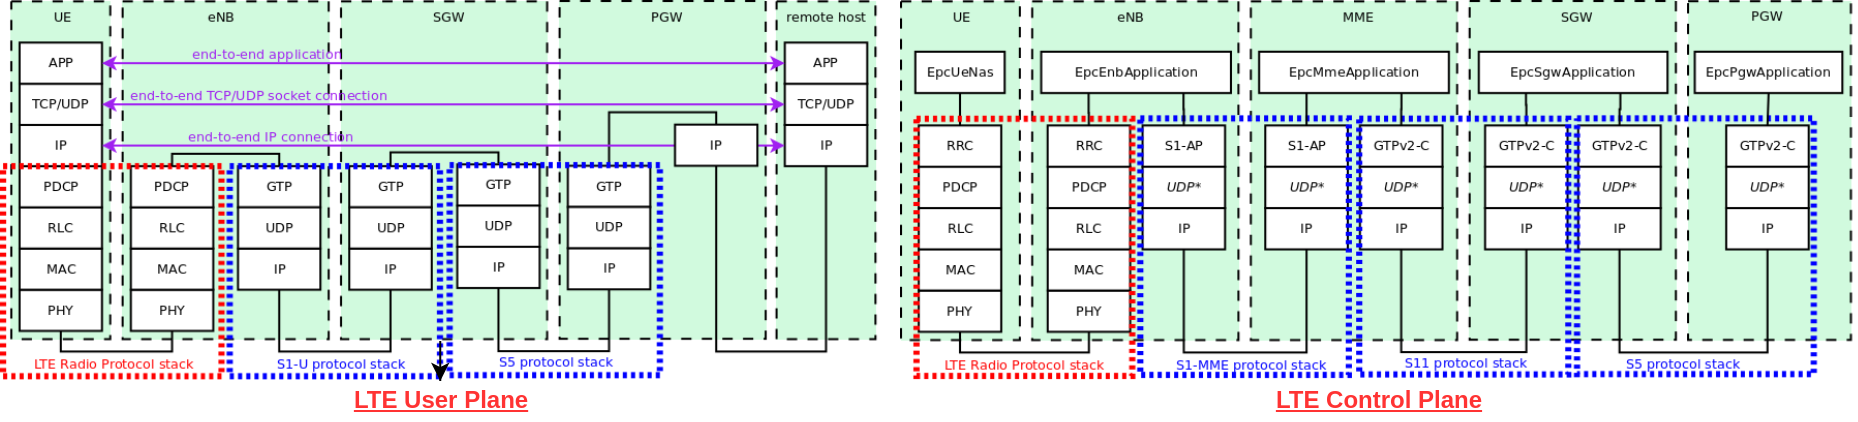
<center>
    <b>Figure. 2: LTE Protocol Stack.</b>
</center>

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# 2. Running a Simulation and Performance Analysis
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Following steps will help us in precise interaction with the ns-3 script in order to alter different simulation parameters and obtain results upon completion. The results will be viewed in different cells in the notebook in order to visualize the performance of the simulation runs. The steps can be repeated with similar code snippets in order to answer different questions in the lab.

## 2.1 Running the initialization script
This script is responsible for the initialization of the simulation design using SEM and the specification of different parameters for the considered network topology implemented in ns-3. The expected outcome is the generation of databases with collected results to be visualized later on. We pass the default value of <u>200</u> for d1 as follows:<br>
**%run -i 'init.py' arg1 ...**

In [ ]:
%run -i 'init.py' 200

## 2.2 Query and filter simulation results
The results from the sem simulation framework are queried and transferred to python for per-processing by defining a set of parameters and using the same simulation campaign that was utilized during the simulation process.

In [ ]:
params_flow = {
    'enableInstTput': True,
    'd1': 200,
}
flow_result = campaign2.db.get_complete_results(params=params_flow)

#The following sample query code snippet will be useful in task#1 & 2 for querying the logs from the ns3 simulation
params_ran = {
    'd1': 200,
}
ran_log_components = {
    'LteEnbMac': 'info',
    'LteEnbRrc': 'info',
    'LteRrcProtocolIdeal': 'info',
    'LteUeRrc': 'info',
    'LteEnbRrc': 'debug',
    'LteRrcProtocolIdeal': 'debug',
}
params_epc = {
    'd1': 200,
}
epc_log_components = {
    'EpcMmeApplication': 'debug',
    'EpcPgwApplication': 'debug',
    'EpcEnbApplication': 'info',
    'EpcSgwApplication': 'info',
}

ran_logs = campaign.db.get_complete_results(params=params_ran, log_components=ran_log_components)
epc_logs = campaign1.db.get_complete_results(params=params_epc, log_components=epc_log_components)


## 2.3 Running the data pre-processing script
This script is responsible for the parsing of simulation data collected during the simulation runs. The expected outcome is the generation of python dataframe **res** for flow results and output for RAN\EPC logs during the connection setup and attachment phase. The logging output can be shown in the notebook by passing a **True** value for display argument when calling the script.

In [ ]:
%run -i 'data-pre.py' 200 True # False for no Logs, True for dislaying logs
# dataframes for visualizing respective results
# res for flows (throughput)

## 2.4 Simulation Results for User Throughput

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(40,10))
snsp1 = sns.lineplot(ax=axes[0], data=res, x='time', y='tput', hue='uid', ci=None)
snsp1.set( xlabel='Simulation Time (s)', ylabel='Throughput (Mbps)')

snsp2 = sns.boxplot(ax=axes[1], data=res, x='uid', y='tput')
snsp2.set( xlabel='Users (uxy, where, x=cellid, y=rnti', ylabel='Throughput (Mbps)')

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Task#1: States, Signalling, Connection Setup in LTE
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
In this task, we will observe the connection setup (those implemented in ns3) for the RAN and EPC parts of the network. The process starts with the communication between UEs and eNBs as the cell search begins for attachement of users to eNBs. This is followed up by random access and the associated states of the UEs and eNBs upon reception of various communication messages from within RAN and the EPC. The process is depicted in Fig. 2, where we will observe the states throughout the simulation duration until data communication starts between users and the remote network. <br>
The state machine implementation in ns3 for the eNB and UE RRC layers are shown in Fig. 2. The users in the a LTE RAN transition through these states upon occurrence of various events.

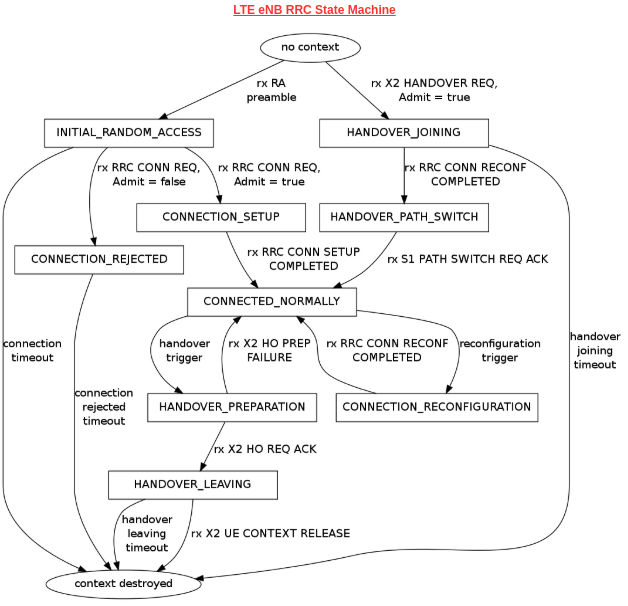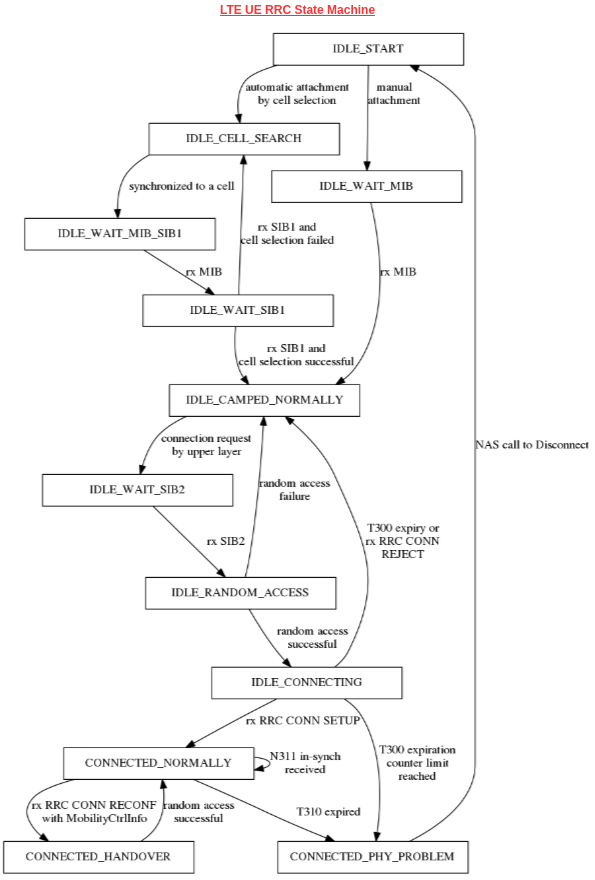
<center>
    <b>Figure. 3: LTE Protocol Stack (eNB and UE).</b>
</center>
The logs contain the information for the relevant node and LTE layer to identify the events from different sources. Consider the following Fig. 3 as an example: <br>

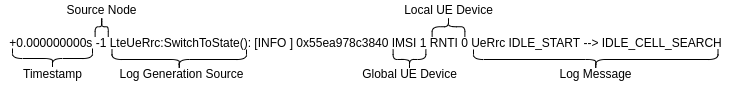
<center>
    <b>Figure. 4: Ns-3 Log structure.</b>
</center>



We design a simulation scenario with <u>d1 = 300</u> to observe the processes associated with connection setup, progression and data transfer.

## Q1. The sequence of events from the RRC layer of UE and eNB are shown in the RAN and EPC level logs. Relate the RRC states with the EPC logs to identify the connection progression for different UEs. Which of the EPC nodes are identifiable in the logs?

## Q2. What are different types of bearers in LTE? Identify any logs relevant to the establishement of bearers?


## Q3. What is the path created between UE and the remote network in the LTE network during connection setup? Consult the logs generated during simulation and identify the relevant logs?

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
# Task#2: Impact of user location on the network connectivity and signalling
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
We have seen how the UEs and eNBs register with the EPC in order to connect and communicate through the network. In this task, the performance of the UE and eNB states in the LTE network near the coverage boundary of the cell will be analyzed. This scenario can be observed by changing either the transmitted power of eNB or by changing the user placement around the eNB. It is expected that the convergence of the UE and eNB states will be effected due to inconsistent and faded and interrupted signal reception due to pathlosses. The students are expected to simulate different parametric constraints on the given network topology in order to determine the absolute edge of the cellular coverage by observing the state of connection and transferred data throughput for individual UEs.

## Scenario 1 
- d1 = 500

## Scenario 2
- d1 = 700

## Scenario 3
- d1 = 1000

## Q1. Observe the RAN and EPC logs for the given scenarios? Are there any connectivity problems for an of the users? If yes, how are they identified from the available results?


## Q2. Find out the approximate boundary of the cell by running simulations for different values of <u> **d1** </u>? Is there any evident impact of propagation loss during transmission of signal to different users?(Hint: d1 effects the positioning of the users around the coverage area)


## Q3. Considering the RAN logs, identify the user which has loss of connectivity in Scenario 2? Which user is it in terms of positioning from Fig. 1?

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------